# Annual Extremes

```{caution}
IN DEVELOPMENT everywhere.
```

## Setup
The usual deal.

In [1]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 
# import utide
from scipy.interpolate import interp1d


# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_daily_hawaii.nc').exists():
    print('rsl_daily_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_daily_hawaii.nc found in ../../data. Proceed.')


# check to make sure that data_dir/rsl_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_hawaii.nc').exists():
    print('rsl_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_hawaii.nc found in ../../data. Proceed.')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jfiedler/Documents/Repositories/SL_Hawaii/SL_Hawaii/notebooks/data/rsl_hawaii.nc'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jfiedler/Documents/Repositories/SL_Hawaii/SL_Hawaii/notebooks/data/rsl_hawaii.nc'

## Obtain Daily and Hourly datasets

In [2]:
#import rsl_daily
rsl_daily_all = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
data_coverage = rsl_daily_all['rsl_mhhw'].count(dim='time')/len(rsl_daily_all.time)

#drop all locations with data_coverage less than 80%
rsl_daily = rsl_daily_all.where(data_coverage>0.80,drop=True)

rsl_hourly = xr.open_dataset(data_dir/ 'rsl_hawaii.nc')
rsl_hourly

# # make rsl_hourly have the same time period as rsl_daily
# rsl_hourly = rsl_hourly.sel(time = slice(rsl_daily.time[0], rsl_daily.time[-1]))

#include only the TGs that are in rsl_subset
rsl_hourly = rsl_hourly.sel(record_id = rsl_daily.record_id.values)

# truncate time period to end at the end of 2022
rsl_daily = rsl_daily.sel(time = slice(None, '2022-12-31'))
rsl_hourly = rsl_hourly.sel(time = slice(None, '2022-12-31'))

# check the last time in rsl_daily and rsl_hourly
print(rsl_daily.time[-1].values)
print(rsl_hourly.time[-1].values)

2022-12-31T00:00:00.000000000
2022-12-31T22:59:59.971200000


## Pre-process the data
### Remove outliers and obtain trend
Here we are using the FULL data set, not just from 1993-onward.

First we'll nan out the tsunami time period, and then calculate the trend.
```{note}
Need to insert code from Ayesha here for tsunami removal, which should be 36 hours only.
```

In [3]:
from pyextremes import get_extremes, get_return_periods, plotting, EVA

# cut data off at end of 2022
rsl_hourly = rsl_hourly.sel(time=slice(None, '2022-12-31'))

rsl_hourly['sea_level_mhhw'] = 0.001*(rsl_hourly['sea_level'] - rsl_hourly['MHHW'])

# replace sea level data with nan for tsunami event from 23-24 May 1960
tsunamiTimeStart = pd.to_datetime('1960-05-23 00:00:00')
tsunamiTimeEnd = pd.to_datetime('1960-05-25 00:00:00')

# nan out the data for the tsunami event
rsl_hourly['sea_level_mhhw'].loc[dict(time=slice(tsunamiTimeStart, tsunamiTimeEnd))] = np.nan


# get trend, trend_rate, trend_mag
trend_mag, trend_line, trend_rate = process_trend_with_nan(rsl_hourly['sea_level_mhhw'])

Make a plot to make sure we're looking at the right thing.

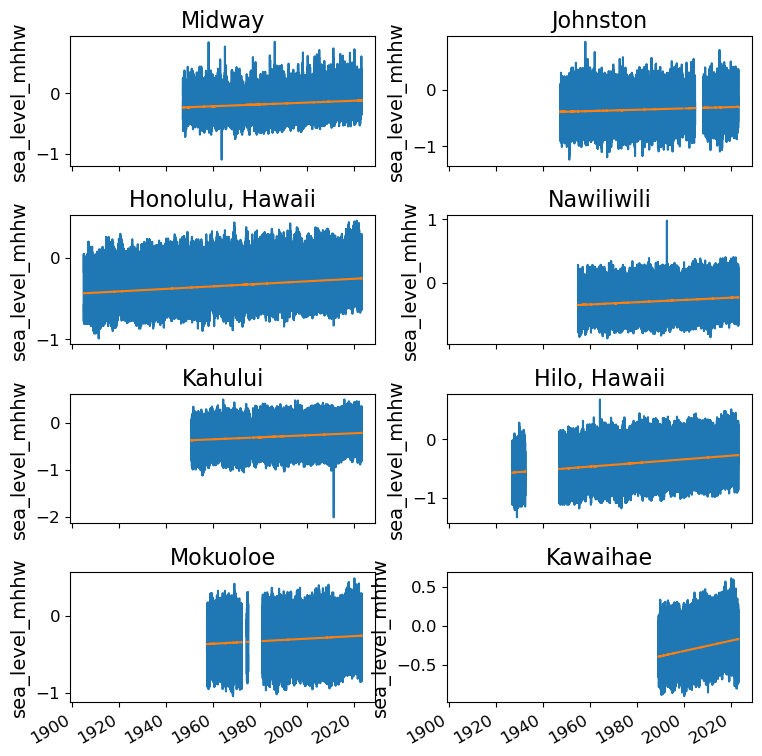

In [4]:
g = rsl_hourly['sea_level_mhhw'].plot(x='time', col='record_id', col_wrap=2, sharey=False, sharex=True, figsize=(8, 8))

# Use g.axs to iterate over the axes in the FacetGrid
for ax, rid in zip(g.axs.flat, rsl_hourly.record_id):
    # Accessing the station_name coordinate for the current record_id directly
    trend_line.sel(record_id = rid).plot(ax = ax)
    station_name = rsl_hourly['station_name'].sel(record_id = rid).values
    ax.set_title(station_name)
    ax.set_xlabel('')

plt.show()


Now we'll turn this data into a timeseries and detrend it (remove the trend line calculated above). This now puts everything relative to mean sea level for the calculated time period. We'll set it back to MHHW (epoch 1993-2001 values).


```{note}
The datum used here is TBD. Ayesha's code uses 1991-2009 to get MHHW.
```

In [4]:
#remove the linear trend, this will put everything at MSL.
rsl_detrended = rsl_hourly['sea_level_mhhw']-trend_line

Next we'll create an xarray full of zeros, so that we can later fill it up with values for our return periods at each station:

In [6]:
# Create a zero xarray
z = np.zeros((8, 4))
return_periods = [2,10,50,100]
return_period_xr = xr.DataArray(z, coords=[rsl_hourly['record_id'].values, return_periods],
                  dims=['record_id', 'return period'])



Next, we'll turn each detrended sea level record into a pandas dataseries for extreme value analysis. This extra formatting step is necessary to ensure that the timesteps are handled correctly. Then we'll set everything relative to MHHW again.

For now, we'll pick a record to highlight ("rid" here stands for Record ID).

Text(0, 0.5, 'Water Level (m, MHHW)\nLinearly Detrended')

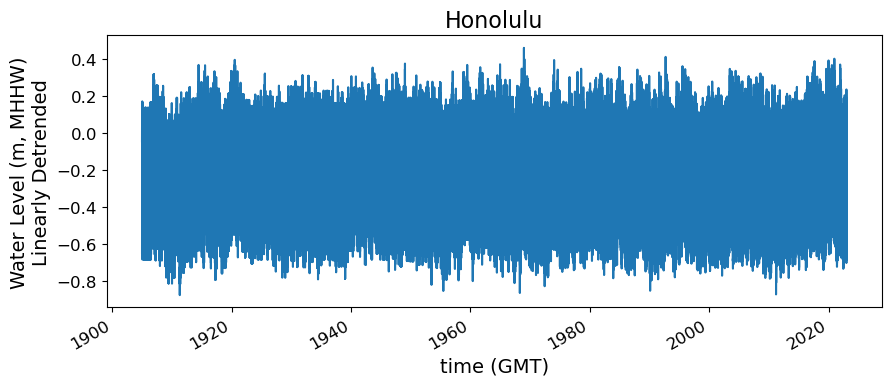

In [5]:
# Turn each detrended sea level record into a series for EVA 
rid = 2
station_name = rsl_hourly['station_name'][rid].item()
if station_name == 'Honolulu, Hawaii':
    station_name = 'Honolulu'

glue('station_name',station_name,display=False)

def convert_to_detrendedMHHW(rid):   
    sea_level_data_detrended = pd.Series(rsl_detrended[rid], index=pd.to_datetime(rsl_hourly['time'].values))
    sea_level_data = pd.Series(rsl_hourly['sea_level_mhhw'][rid], index=pd.to_datetime(rsl_hourly['time'].values))

    # drop the nan values
    sea_level_data_detrended = sea_level_data_detrended.dropna()
    sea_level_data = sea_level_data.dropna()

    # set everything relative to MHHW from MSL coordinates
    MSLtoMHHW = np.round(rsl_hourly['MSL'][rid].values/1000-rsl_hourly['MHHW'][rid].values/1000,4)
    MSLtoMHHW

    sea_level_data_detrended = sea_level_data_detrended + MSLtoMHHW
    # label the data
    sea_level_data_detrended.name = 'sea level [m MHHW, detrended]'
    sea_level_data_detrended.index.name = 'time (GMT)'
    return sea_level_data_detrended
    # plot sea_level_data_detrended

sea_level_data_detrended =  convert_to_detrendedMHHW(rid)   
ax = sea_level_data_detrended.plot() # This should be in MHHW datum, check to see if it makes sense.

# add title
ax.set_title(station_name)
ax.set_ylabel('Water Level (m, MHHW)\nLinearly Detrended')

## Create the model, and extract the extreme values.
Here, we are going to find extremes using the Block Maxima (BM) method. This will find all extreme values by selecting a block size (here we've chosen a year for the annual max, and 30 days for the monthly max). 

In [6]:
min_last_block_ratio = 0.9
model = EVA(sea_level_data_detrended)
model.get_extremes(extremes_type='high', method='BM', block_size='365D',min_last_block=min_last_block_ratio, errors='coerce')

Take a look at the extreme events, here calculated with BM method.

Text(0.5, 1.0, 'Annual Maxima: Honolulu')

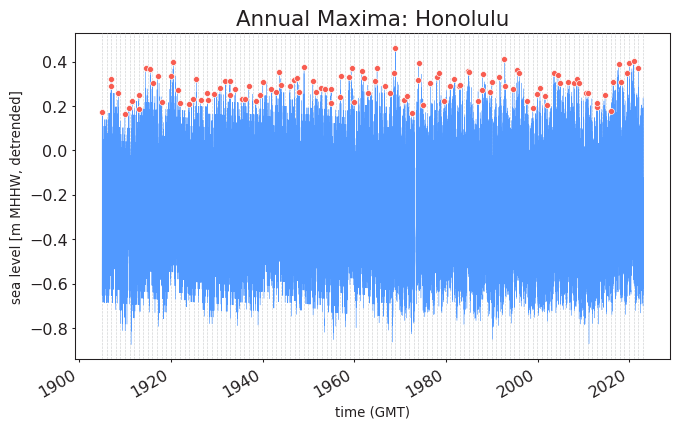

In [7]:
fig, ax = model.plot_extremes()
ax.set_title('Annual Maxima: ' + station_name)

## Fit the model
We are going to take our extremes and fit them to a model. The pyextremes package will select the 'best model' for this using the Akaike Information Criterion (AIC), with the goal of losing the least amount of information in a given model. Using BM, we could have either a GEV or a Gumbel (specialized case of the GEV) distribution. While we could force it to either distribution, for this case we'll the AIC play out.

In [8]:
model.fit_model()

distribution_name = model.distribution.name
if distribution_name == 'genextreme':
    distribution_name = 'GEV'
    
glue("distribution name", model.distribution.name, display=False)


Here, we are using the {glue:text}`distribution name` distribution. Now, we'll print out the shape, location, and scale parameters. 

If we are using the GEV distribution, we'll have 3 parameters (shape, scale, and location) using the Maximum Likelihood Estimation (MLE). 
If we are using the gumbel distribution, there are only 2 free parameters: location and scale (as the GEV approaches Gumbel when the shape parameter goes to zero.)

In [9]:
if model.distribution.name == 'gumbel_r':
    shape = 0
else:
    shape = model.distribution.mle_parameters['c']
scale = model.distribution.mle_parameters['scale']
loc = model.distribution.mle_parameters['loc']

# Format with two decimal places
shape_str = f'{shape:.2f}'
scale_str = f'{scale:.2f}'
loc_str = f'{loc:.2f}'

glue("shape", shape_str, display=False)
glue("scale", scale_str, display=False)
glue("loc", loc_str, display=False)


```{note}
Need to fix this explanation, as each gauge is currently different!
```

For the {glue:text}`station_name` tide gauge, the shape parameter $\xi$ is {glue:text}`shape`, corresponding to a {glue:text}`distribution name` distribution of the extremes. The location parameter $\mu$ tells us that the distribution is centered around {glue:text}`loc`, and the scale parameter ($\psi$  = {glue:text}`scale`} shows how tightly the extremes cluster with each other (little dispersion).

### Let's get a closer look at the return level curve


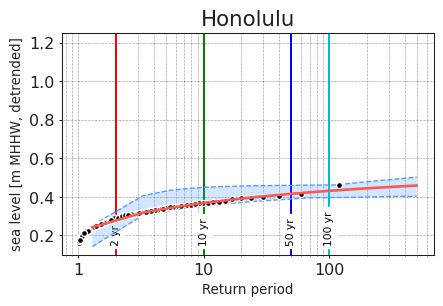

In [10]:
def plot_returnLevelCurve(rid):
    fig,ax = model.plot_return_values(alpha=0.95, return_period=np.arange(1.3,500,2),n_samples=1000, plotting_position='weibull')
    ax.set_ylim(0.1,1.25)

    # add lines for the 2, 5, 10, 50, and 100 year return periods
    return_periods = [2,10,50,100]

    colors = ['r','g','b','c']
    for return_period, color in zip(return_periods, colors):
        ax.axvline(x=return_period, color=color, label=f'{return_period} year return period')
        ax.text(return_period, 0.15, f'{return_period} yr', rotation=90, 
            verticalalignment='bottom',backgroundcolor='w',horizontalalignment='center',
            fontsize=8)

    fig.set_size_inches(5,3)
    ax.set_title(station_name)
    # save the figure
    figname = 'SL_extremes_return_values_'+ station_name + '.png'
    plt.savefig(output_dir / figname, dpi=300, bbox_inches='tight')
    plt.show()

plot_returnLevelCurve(rid)

Confidence intervals for the GEV model are shown in shaded blue. Note that the extreme annual maximum (0.45) does not fall neatly on this distribution, suggesting that perhaps we might need to switch to a non-stationary model to account for the influence of other variables that change with time.

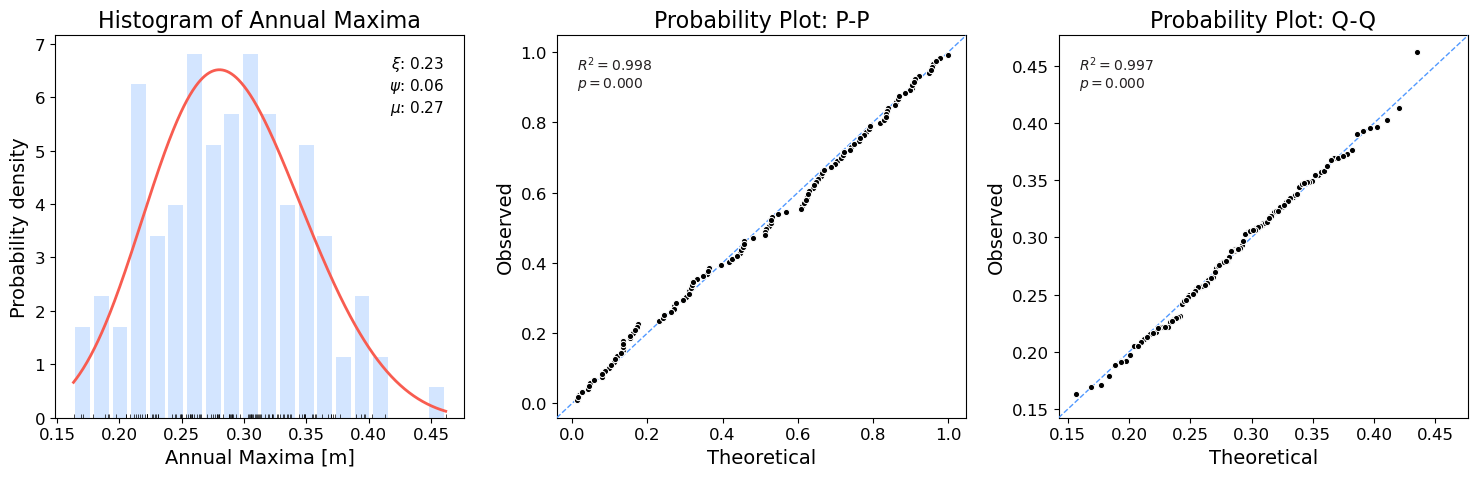

In [11]:
def plot_stats(rid):
    # make new figure with axes 1-3
    fig, axs = plt.subplots(1,3, figsize=(15,5))

    # make pdf of extremes
    pdf_extremes = np.linspace(model.extremes.min(), model.extremes.max(), 500)
    pdf = model.model.pdf(model.extremes_transformer.transform(pdf_extremes))

    axs[0].hist(
                model.extremes.values,
                bins=np.histogram_bin_edges(a=model.extremes.values, bins=20),
                density=True,
                rwidth=0.8,
                facecolor="#5199FF",
                edgecolor="None",
                lw=0,
                alpha=0.25,
                zorder=5,
            )

    axs[0].plot(pdf_extremes, pdf, color="#F85C50", lw=2, ls="-", zorder=15)

    axs[0].scatter(
                model.extremes.values,
                np.full(shape=len(model.extremes), fill_value=0),
                marker="|",
                s=40,
                color="k",
                lw=0.5,
                zorder=15,
            )

    # add parameters to the plot
    axs[0].text(
        0.95,
        0.95,
        f"$\\xi$: {shape_str}\n$\\psi$: {scale_str}\n$\\mu$: {loc_str}",
        fontsize=11,
        ha="right",
        va="top",
        transform=axs[0].transAxes  # Updated to 'axs.transAxes' assuming axs is a single axis object
    )


    axs[0].set_xlabel('Annual Maxima [m]')
    axs[0].set_ylabel("Probability density")

    model.plot_probability('PP',ax=axs[1])
    model.plot_probability('QQ',ax=axs[2])

    axs[0].set_title('Histogram of Annual Maxima')
    axs[1].set_title('Probability Plot: P-P')
    axs[2].set_title('Probability Plot: Q-Q')
    fig.tight_layout()

    # add a supertitle??


    # save the figure
    figname = 'SL_extremes_histogram_pp_qq_'+ station_name + '.png'

    plt.savefig(output_dir / figname, dpi=300, bbox_inches='tight')

plot_stats(rid)

### Get return periods of 2, 10, 50 and 100 years

In [12]:
# Get summary of the model
return_periods=[2, 10, 50, 100]

summary = model.get_summary(
    return_period=return_periods,
    alpha=0.95, n_samples=1000
)

#change name "return period" to "return period (yrs)"
summary = summary.rename(columns={'return period': 'return period (yrs)','return value':'Water Level (m, MHHW)','lower ci':'Lower CI (m, MHHW)','upper ci':'Upper CI (m, MHHW)'})
summary


,"Water Level (m, MHHW)","Lower CI (m, MHHW)","Upper CI (m, MHHW)"
return period,,,
2.0,0.286112,0.274255,0.341391
10.0,0.367975,0.351606,0.449280
50.0,0.415909,0.389592,0.459952
100.0,0.431348,0.396419,0.461007


```{note}
Need to do some fixing here w.r.t. data gaps
```

In [15]:
# get return periods (2,10,50,100) for all stations:

if not (output_dir / 'return_period_stationary.nc').exists():
    for rec_id in np.arange(0,8,1):
        sea_level_data_detrended_temp =  convert_to_detrendedMHHW(rec_id)  
        min_last_block_ratio = 0.9
        model = EVA(sea_level_data_detrended_temp)
        model.get_extremes(extremes_type='high', method='BM', block_size='365D',min_last_block=min_last_block_ratio, errors='ignore')
        model.fit_model()
        summary = model.get_summary(
            return_period=return_periods,
            alpha=0.95, n_samples=1000
        )

        #change name "return period" to "return period (yrs)"
        summary = summary.rename(columns={'return period': 'return period (yrs)','return value':'Water Level (m, MHHW)','lower ci':'Lower CI (m, MHHW)','upper ci':'Upper CI (m, MHHW)'})
        summary

        return_period_xr[rec_id] = summary['Water Level (m, MHHW)']
    return_period_xr.to_netcdf(output_dir / 'return_period_stationary.nc')
else:
    return_period_xr = xr.open_dataarray(output_dir/ 'return_period_stationary.nc')


### Make an intergrated rankings + return periods table

First, make some functions to get the top 10 ranked recorded water levels. This is copied from the rankings notebook.

In [14]:
def get_top_10_table(rsl_subset,rid):
    # make a table of the top 10 values, sorted by size and with date
    top_10_values_max = get_top_ten(rsl_subset, rid, mode='max')
    top_10_values_min = get_top_ten(rsl_subset, rid, mode='min')

    top_10_table = pd.concat([top_10_values_max,top_10_values_min])

    return top_10_table

def get_top_ten(rsl_subset, rid, mode='max'):
    # Convert data to a pandas Series
    sea_level_series = rsl_subset.sea_level.isel(record_id=rid).to_series()


   # Select top 100 values based on the mode
    if mode == 'max':
        top_values = sea_level_series.nlargest(100)
    elif mode == 'min':
        top_values = sea_level_series.nsmallest(100)
    else:
        raise ValueError('mode must be either "max" or "min"')

    # Filter to find unique events spaced by at least 3 days
    filtered_dates = []
    top_10_values = pd.Series()

    for date, value in top_values.items():
        if all(abs((date - pd.to_datetime(added_date)).days) > 3 for added_date in filtered_dates):
            filtered_dates.append(date)
            top_10_values[date] = value
        if len(filtered_dates) == 10:
            break
    rank = np.arange(1,11)

    station_name = str(rsl_subset['station_name'].isel(record_id=rid).values)
    record_id = str(rsl_subset['record_id'].isel(record_id=rid).values)  

    top_10_values = pd.DataFrame({'rank': rank, 'date': top_10_values.index, 'sea level (m)': top_10_values.values})  
    top_10_values['station_name'] = station_name
    top_10_values['record_id'] = record_id
    top_10_values['type'] = mode

    #round the date to the nearest hour
    top_10_values['date'] = top_10_values['date'].dt.round('h')

    return top_10_values

### First make the rankings list

In [15]:

rsl_subset = rsl_hourly.copy()
rsl_subset['sea_level'] = rsl_subset['sea_level_mhhw']
SL_rankings10 = get_top_10_table(rsl_subset,rid)

# take only the max type
SL_rankings10 = SL_rankings10[SL_rankings10['type']=='max']
SL_rankings10

,rank,date,sea level (m),station_name,record_id,type
0,1,2020-12-15 15:00:00,0.458,"Honolulu, Hawaii",570,max
1,2,2019-12-25 14:00:00,0.447,"Honolulu, Hawaii",570,max
2,3,2017-08-21 01:00:00,0.440,"Honolulu, Hawaii",570,max
3,4,1968-12-19 14:00:00,0.436,"Honolulu, Hawaii",570,max
4,5,2021-12-05 15:00:00,0.428,"Honolulu, Hawaii",570,max
5,6,1992-09-12 02:00:00,0.424,"Honolulu, Hawaii",570,max
6,7,2020-07-20 02:00:00,0.423,"Honolulu, Hawaii",570,max
7,8,2020-11-15 14:00:00,0.415,"Honolulu, Hawaii",570,max
8,9,2020-10-19 16:00:00,0.411,"Honolulu, Hawaii",570,max
9,10,2017-06-24 02:00:00,0.410,"Honolulu, Hawaii",570,max


Now we'll add in the return period table

In [16]:
# mix this dataframe in with the SL_rankings table:
station_name = station_name

# extract only 'Highest' and 'Highest Date' columns
SL_rankings = SL_rankings10[['date','sea level (m)']]

#rename 'Highest' to sea level (m, MHHW)
SL_rankings = SL_rankings.rename(columns={'sea level (m)':'Water Level (m, MHHW)'})

# Ensure 'Water Level (m, MHHW)' column is numeric for both DataFrames
SL_rankings['Water Level (m, MHHW)'] = pd.to_numeric(SL_rankings['Water Level (m, MHHW)'], errors='coerce')
summary['Water Level (m, MHHW)'] = pd.to_numeric(summary['Water Level (m, MHHW)'], errors='coerce')

# Merge the SL_rankings DataFrame with the summary DataFrame on 'water level (m, MHHW)'
SL_rankings_merge = pd.merge(SL_rankings, summary.reset_index(), on='Water Level (m, MHHW)', how='outer')

SL_rankings_merge = SL_rankings_merge.sort_values('Water Level (m, MHHW)',ascending=False)

SL_rankings_merge['Date or Return Period'] = SL_rankings_merge.apply(
    lambda row: row['date'] if pd.notnull(row['date']) else row['return period'], axis=1
)

SL_rankings_merge = SL_rankings_merge.drop(columns=['date','return period','Lower CI (m, MHHW)','Upper CI (m, MHHW)'])

# Add a column for feet
SL_rankings_merge['Water Level (ft, MHHW)'] = SL_rankings_merge['Water Level (m, MHHW)']*3.28084

# Rearrange columns to Date or Return Period, water level (m, MHHW), water level (ft, MHHW)
SL_rankings_merge = SL_rankings_merge[['Date or Return Period','Water Level (m, MHHW)','Water Level (ft, MHHW)']]


### Format the merged rankings and return period table
Format this to match https://sealevel.nasa.gov/flooding-analysis-tool/observed-flooding?station-id=1612340&scenario=int-low&threshold=061&map=hide

In [17]:
# Format the date to be in the format 'YYYY-MM-DD' if a date, or '10-year flood' if a return period
SL_rankings_merge['Date or Return Period'] = SL_rankings_merge['Date or Return Period'].apply(
    lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else f'{int(x)}-year flood' if isinstance(x, (int, float)) else x
)

# Format the water level columns to have 2 decimal places
SL_rankings_merge['Water Level (m, MHHW)'] = SL_rankings_merge['Water Level (m, MHHW)'].round(2)
SL_rankings_merge['Water Level (ft, MHHW)'] = SL_rankings_merge['Water Level (ft, MHHW)'].round(2)

# export the table to a csv file
csvname = 'SL_extremes_' + station_name + '.csv'
SL_rankings_merge.to_csv(output_dir / csvname, index=False)


SL_rankings_merge

,Date or Return Period,"Water Level (m, MHHW)","Water Level (ft, MHHW)"
0,2020-12-15,0.46,1.50
1,2019-12-25,0.45,1.47
2,2017-08-21,0.44,1.44
3,1968-12-19,0.44,1.43
13,100-year flood,0.43,1.42
4,2021-12-05,0.43,1.40
5,1992-09-12,0.42,1.39
6,2020-07-20,0.42,1.39
12,50-year flood,0.42,1.36
7,2020-11-15,0.42,1.36


In [18]:
# make into a table with great_tables
from great_tables import GT, html, md

In [19]:
# make a copy of the DataFrame
SL_rankings_merge_copy = SL_rankings_merge.copy()

# replace all spaces with underscores in top_10_display column names
# SL_rankings_merge_copy.columns = SL_rankings_merge_copy.columns.str.replace(' ', '_')

# replace column names 
SL_rankings_merge_copy.columns = ['Date_or_Return_Period', 'mMHHW', 'ftMHHW']


In [20]:
# Convert the DataFrame to a great_table
(
    GT(SL_rankings_merge_copy)
    .tab_header(title='Highest Sea Level Events', subtitle='Station: '+station_name)
    .cols_align('center')
    .cols_label(Date_or_Return_Period=html("Date or <br>Return Period"), mMHHW=html('Water Level <br>(m, MHHW)'),ftMHHW = html('Water Level <br>(ft, MHHW)'))
    .tab_source_note(source_note='Source: UHSLC RQDS')
    .save('../../output/SL_rankings_merge_'+ station_name + '.png')
)

Note I'm not really sure why the water level values don't match Phil's table. My guess is that we're working off slightly different datums?

## Make a map
### Plot the Return Periods at each station
Note that we are neglecting the confidence intervals for now.

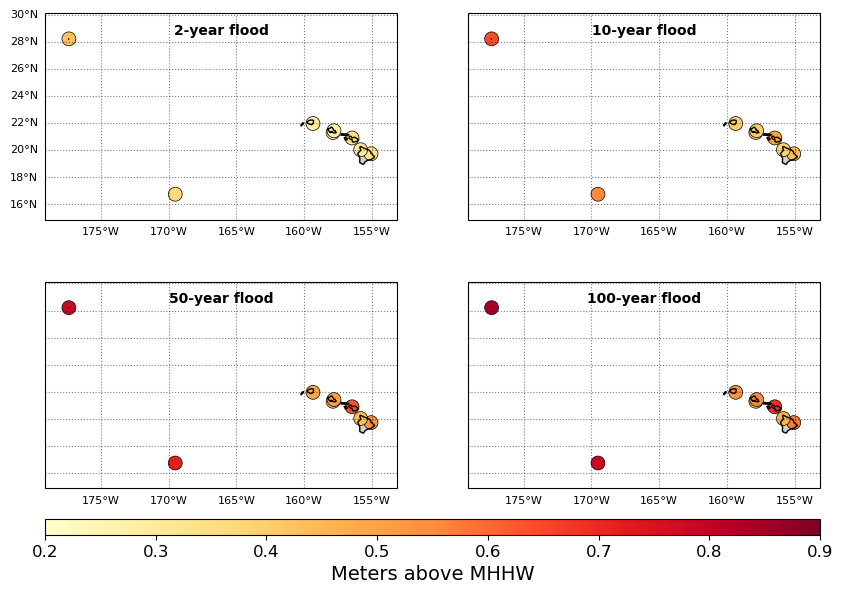

In [23]:
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2,2,figsize=(10, 8), subplot_kw={'projection': crs})
# make ax,fig
# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.25deg_1993_2023.nc')

xlims = [cmems.longitude.min(), cmems.longitude.max()]
ylims = [cmems.latitude.min(), cmems.latitude.max()]


# plt.colorbar(maxplt,ax=axs[0],label='Sea Level (m)', location='bottom')           

for i, ax in enumerate(axs.flat):

    ax.scatter(rsl_hourly['lon'], rsl_hourly['lat'], transform=crs, s=100, 
               c=return_period_xr[:,i], vmin=0.2, vmax=0.9, cmap='YlOrRd',
               linewidth=0.5, edgecolor='black')
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    # set extent
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=crs)

    #add grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    if i>=0:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # add text to top left of plot
    ax.text(0.5, 0.95, f'{return_periods[i]}-year flood', color='black', fontsize=10, weight='bold',
            transform=ax.transAxes, ha='center', va='top', zorder=10)

# add colorbar to the bottom of the plot which follows vmin, vmax and cmap of the scatter plot
# colorbar should be 
cbar = plt.colorbar(axs[1, 1].collections[0], ax=axs, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Meters above MHHW')

# save the figure
plt.savefig(output_dir / 'SL_extremes_map.png', dpi=300, bbox_inches='tight')

## Plot a timeseries

/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/pyextremes/extremes/block_maxima.py:138: NoDataBlockWarning: 7 blocks contained no data
  warnings.warn(


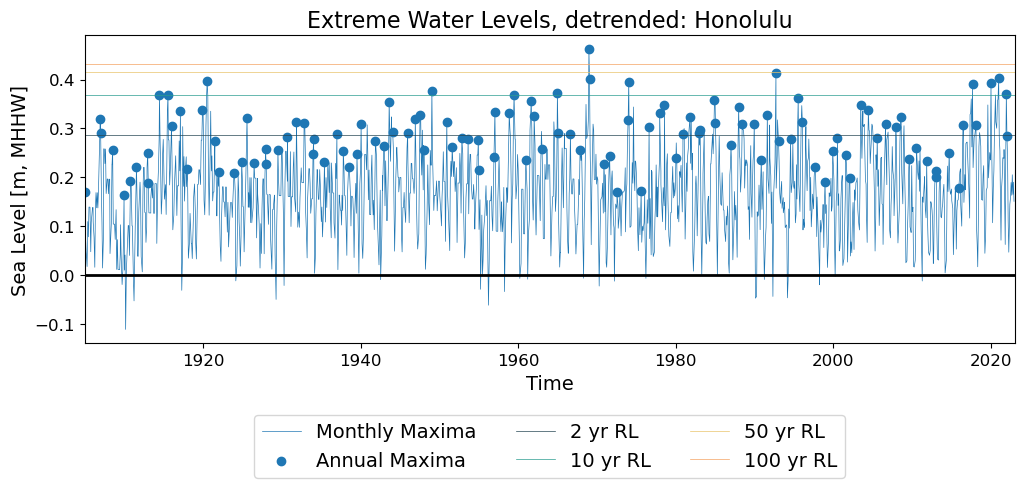

In [21]:
# plot the monthly maxima
monthly_max = get_extremes(sea_level_data_detrended, method='BM', 
                           extremes_type='high', block_size='30D', min_last_block=0.9, errors='coerce')
annual_max = get_extremes(sea_level_data_detrended, method='BM', extremes_type='high', block_size='365.245D', min_last_block=0.9, errors='coerce')

model.get_extremes(extremes_type='high', method='BM', block_size='365D',min_last_block=min_last_block_ratio, errors='coerce')

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(monthly_max.index, monthly_max, label='Monthly Maxima',linewidth=0.5)
ax.scatter(annual_max.index, annual_max, label='Annual Maxima')
ax.set_xlabel('Time')
ax.set_ylabel('Sea Level [m, MHHW]')
ax.set_title(f'Extreme Water Levels, detrended: {station_name}')

colors = ['#264653',  # dark cyan
          '#2a9d8f',  # teal
          '#e9c46a',  # sandy yellow
          '#f4a261']  # sandy orange

# add the 2, 10, 50, and 100 year return levels in horizontal lines
for i,period in enumerate(return_periods):
    ax.axhline(summary.loc[period, 'Water Level (m, MHHW)'], label=f'{period} yr RL', color=colors[i],linewidth=0.5)

# add bold black line at 0 for MHHW
ax.axhline(0, color='black', linewidth=2)
ax.legend()
# put the legend at the bottom of the plot in one row
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax.set_xlim([rsl_hourly['time'].values[0], rsl_hourly['time'].values[-1]])

# save the figure
figname = 'SL_extremes_monthly_annual_maxima_' + station_name + '.png'
plt.savefig(output_dir / figname, dpi=300, bbox_inches='tight')

One takeaway here: Removing the trend shows that we've had some significant events in the past (including the large pulse in the 1970s) that do not show up in our rankings.  

In [22]:
import plotly.graph_objects as go


fig = go.Figure()

# Add monthly maxima as a line
fig.add_trace(go.Scatter(x=monthly_max.index, y=monthly_max, mode='lines', name='Monthly Maxima', line=dict(width=0.5)))

# Add annual maxima as scatter points
fig.add_trace(go.Scatter(x=annual_max.index, y=annual_max, mode='markers', name='Annual Maxima'))


colors = ['#264653',  # dark cyan
          '#2a9d8f',  # teal
          '#e9c46a',  # sandy yellow
          '#f4a261']  # sandy orange


# Add return levels as labeled lines
for i, period in enumerate(return_periods):
    fig.add_trace(go.Scatter(x=[monthly_max.index.min(), monthly_max.index.max()],
                             y=[summary.loc[period, 'Water Level (m, MHHW)']] * 2,
                             mode='lines',
                             line=dict(color=colors[i], width=1),
                             name=f'{period} year RL'))
    
# Add a bold black line at 0 for MHHW
fig.add_hline(y=0, line=dict(color='black', width=2))

# Set titles and labels
fig.update_layout(title=f'Extreme Water Levels, Stationary GEV: {station_name}',
                  xaxis_title='Time',
                  yaxis_title='Sea Level [m, MHHW, detrended]',
                  legend=dict(x=0.5, xanchor='center', y=-0.2, orientation='h', bgcolor='rgba(255,255,255,0.8)'),
                  plot_bgcolor='white',  # Set plot background to white
                  paper_bgcolor='white')  # Set overall background to white

# Set x-axis limits if needed
fig.update_xaxes(range=[monthly_max.index.min(), monthly_max.index.max()])

# Show the figure
fig.show()

# save the figure
figname = 'SL_extremes_monthly_annual_maxima_' + station_name + '.html'

fig.write_html(output_dir / figname)